In [11]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import decord
import json
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import PIL.Image
from glob import glob
from natsort import natsorted

import shared.utils as su
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
)

**Load model**

In [55]:
from models.modeling_encoders import AutoEncoder

# model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint"
model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/"\
    "nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint"
encoder = AutoEncoder.from_pretrained(model_id, device_map='cuda:0')
su.misc.num_params(encoder.model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


### ActivityNet

In [26]:
video_dir = "/datasets/ActivityNet/2020-version/activitynet_frames"

# video_dir = "/scratch/shared/beegfs/piyush/datasets/ActivityNetCaptions/videos/v1-2/test/"
data_dir = "/scratch/shared/beegfs/piyush/datasets/PseudoAdverbs"

df_anno = pd.read_csv(f"{data_dir}/datasets/ActivityNet_Adverbs/annotations.csv")
df_advb = pd.read_csv(f"{data_dir}/datasets/ActivityNet_Adverbs/adverbs.csv")
print(df_anno.shape, df_advb.shape)

# ext = 'mp4'
# df_anno['video_path'] = df_anno.clip_id.apply(lambda x: f"{video_dir}/{x}.{ext}")
# df_anno = df_anno[df_anno['video_path'].apply(os.path.isdir)]
# print("Number of rows with video available: ", len(df_anno))

adverb_to_antonym = dict(df_advb.values)
len(adverb_to_antonym)

(3099, 10) (20, 2)


20

In [14]:
def get_frame_ends(clip_id, n_frames=16, fps=5):
    # clip_id = os.path.basename(clip_folder)
    video_id = clip_id[:13]
    frame_dir = f"{video_dir}/{video_id}"
    assert os.path.isdir(frame_dir), f"{frame_dir}"
    start_time, end_time = clip_id.split("_")[-2:]
    start_time = float(start_time)
    end_time = float(end_time)
    
    paths = natsorted(glob(f"{frame_dir}/*.jpg"))
    sf = int(start_time * fps)
    ef = min(int(end_time * fps), len(paths))
    return sf, ef

sf = []
ef = []
from tqdm import tqdm
tqdm.pandas(desc='Get start and end frames')
out = df_anno.clip_id.progress_apply(get_frame_ends)

Get start and end frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3099/3099 [00:53<00:00, 58.03it/s]


In [16]:
np.array(out)

array([(35, 90), (95, 440), (840, 1070), ..., (370, 385), (35, 135),
       (20, 90)], dtype=object)

In [27]:
out_arr = np.array([list(x) for x in out])
indices_to_keep = np.where((out_arr[:, 1] - out_arr[:, 0]) > 16)[0]
df_anno = df_anno.iloc[indices_to_keep]
df_anno.shape

(2901, 10)

In [28]:
# plt.hist((out_arr[:, 1] - out_arr[:, 0]), bins=100);

In [29]:
df_anno

,Unnamed: 0,clip_id,youtube_id,start_time,end_time,action,adverb,caption,clustered_action,clustered_adverb
0,0,v_ogQozSI5V8U_7_18,ogQozSI5V8U,7.49,18.09,walk,slowly,A dog in socks walks slowly out onto the floo...,walk,slowly
1,1,v_D18b2IZpxk0_19_88,D18b2IZpxk0,19.61,88.01,lean,forward,The camel walks as the woman leans forward.,tilt,forwards
2,2,v_oP77DgsbhKQ_168_214,oP77DgsbhKQ,168.46,214.60,look,back,He continues laying tiles on the floor while ...,look,backwards
3,3,v_fzp5ooc727c_66_72,fzp5ooc727c,66.74,72.68,throw,back,The ball is thrown back and he its it again.,throw,backwards
4,4,v_IoiDAHNryTk_19_47,IoiDAHNryTk,19.99,47.04,climb,back,She climbs her way back on the bars and jumps...,climb,backwards
...,...,...,...,...,...,...,...,...,...,...
3093,3093,v_HNR_HofJ_Fs_0_20,HNR_HofJ_Fs,0.00,20.14,walk,in,A man is seen moving around an airplane when a...,walk,in
3094,3094,v_JZz2O0y0ufY_8_14,JZz2O0y0ufY,8.00,14.28,swing,down,Finally he swings it back down.,swing,downwards
3095,3095,v_WV-Sf5-aCcc_27_86,WV-Sf5-aCcc,27.99,86.92,move,back,He begins moving back and fourth moving his b...,move,backwards
3097,3097,v_V3LvKGRzkeg_7_27,V3LvKGRzkeg,7.48,27.60,play,up,People are playing music up on a stage.,play,upwards


 The left man squats down as the other leans forward.

squat/downwards

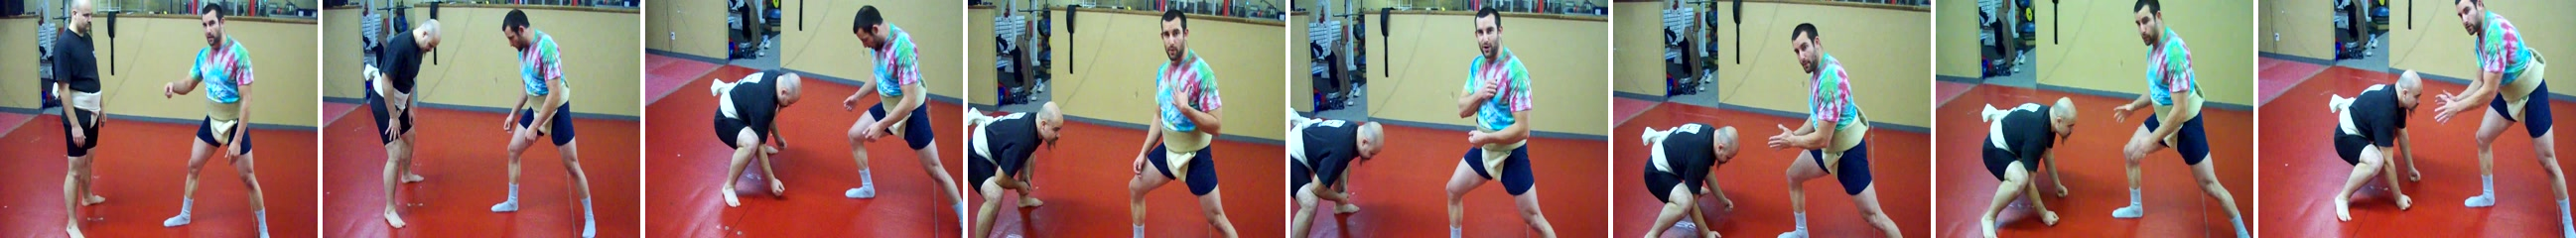

In [53]:
def read_frames(clip_id, n_frames=16, fps=5):
    # clip_id = os.path.basename(clip_folder)
    video_id = clip_id[:13]
    frame_dir = f"{video_dir}/{video_id}"
    assert os.path.isdir(frame_dir), f"{frame_dir}"
    start_time, end_time = clip_id.split("_")[-2:]
    start_time = float(start_time)
    end_time = float(end_time)
    
    paths = natsorted(glob(f"{frame_dir}/*.jpg"))
    sf = int(start_time * fps)
    ef = min(int(end_time * fps), len(paths))
    assert sf < ef
    n_frames = min(n_frames, ef - sf)
    indices = np.linspace(sf, ef, n_frames, endpoint=False, dtype=int)
    paths = np.array(paths)[indices]
    frames = [PIL.Image.open(f).convert("RGB") for f in paths]
    x = torch.stack(
        [torch.from_numpy(np.asarray(f)) for f in frames]
    )
    x = x.permute(0, 3, 1, 2)  # (T, C, H, W), torch.uint8
    return x


# frame_dir = "/datasets/ActivityNet/2020-version/activitynet_frames/v_ogQozSI5V8U"
# x = read_frames(frame_dir)
# x.shape

i = np.random.randint(len(df_anno))
row = df_anno.iloc[i]
frames = read_frames(row.clip_id)

display(Markdown(row.caption))
display(Markdown(f"{row.clustered_action}/{row.clustered_adverb}"))
su.visualize.concat_images_with_border(
    [PIL.Image.fromarray(x.numpy()) for x in frames.permute(0, 2, 3, 1)[::2]]
)

In [57]:
def embed_video_action(clip_id, action, n_frames=16, verbose=False):

    PROMPT = "Video: <video>\n"\
             "Action: This video shows the action: <sent>\n"\
             "Look at the video carefully.\n"\
             "Summarize the action in the video in one word:"
    PROMPT = f"USER: {PROMPT} ASSISTANT: "

    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    # Prepare video
    # pixel_values = read_frames_decord(video_path, n_frames)
    pixel_values = read_frames(clip_id, n_frames).unsqueeze(0)
    pixel_values = transform_pixel_values(pixel_values)
    nframes = pixel_values.shape[1]
    to_image = ToPILImage()
    batched_frames = []
    for batch in pixel_values:
        frames = [to_image(v) for v in batch]
        batched_frames.append(frames)

    for frames in batched_frames:

        # Video
        input_prompt = PROMPT.replace("<video>", "<image>"*len(frames))

        # Text
        input_prompt = input_prompt.replace('<sent>', action)

        if verbose:
            print(input_prompt)
            print("-" * 120)

        input_ids = encoder.processor.get_text_inputs(input_prompt)
        frames = encoder.processor.get_pixel_values(frames)
        inputs = {
            "input_ids": input_ids,
            "pixel_values": frames
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        zv = outputs.hidden_states[0][-1][:, -1, :]
        break # Safe to break since it is just one video

    if verbose:
        print(zv.shape)

    return zv.squeeze(0)


i = 0
row = df_anno.iloc[i].to_dict()
zv = embed_video_action(
    row['clip_id'], row['clustered_action'], n_frames=32, verbose=True
)
zv = torch.nn.functional.normalize(zv, dim=-1).cpu().float()
zv.shape

USER: Video: <image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image>
Action: This video shows the action: walk
Look at the video carefully.
Summarize the action in the video in one word: ASSISTANT: 
------------------------------------------------------------------------------------------------------------------------
torch.Size([1, 4096])


torch.Size([4096])

In [62]:
# Compute video-action embeddings
video_embeds = {}
n_frames = 2
for i in su.log.tqdm_iterator(
    range(len(df_anno)), desc='Computing features for videos'
):
    row = df_anno.iloc[i].to_dict()
    try:
        zv = embed_video_action(row['clip_id'], row['clustered_action'], n_frames=n_frames)
        zv = torch.nn.functional.normalize(zv, dim=-1).cpu().float()
        video_embeds[row['clip_id']] = zv
    except:
        print(f"Failed {row['clip_id']}.")
        continue
len(video_embeds)

Computing features for videos:   0%|          | 0/2901 [00:00<?, ?it/s]

2781

In [59]:
def embed_adverb_action(adverb, action, n_frames=16, verbose=False):
    prompt = f"The action {action} is performed {adverb}."
    with torch.no_grad():
        zt = encoder.encode_text(prompt).cpu().squeeze(0).float()
        zt = torch.nn.functional.normalize(zt, dim=-1)
    return zt


i = 0
row = df_anno.iloc[i].to_dict()
zt = embed_adverb_action(
    row['clustered_adverb'], row['clustered_action'], verbose=True
)
zt.shape

torch.Size([4096])

In [60]:
text_embeds = {}
for i in su.log.tqdm_iterator(
    range(len(df_anno)), desc='Computing features for videos'
):
    row = df_anno.iloc[i].to_dict()
    key = f"{row['clustered_action']}/{row['clustered_adverb']}"
    if key in text_embeds:
        continue
    zv = embed_adverb_action(row['clustered_adverb'], row['clustered_action'])
    zv = torch.nn.functional.normalize(zv, dim=-1).cpu().float()
    text_embeds[key] = zv

    antonym = adverb_to_antonym[row['clustered_adverb']]
    key = f"{row['clustered_action']}/{antonym}"
    if key in text_embeds:
        continue
    zv = embed_adverb_action(antonym, row['clustered_action'])
    zv = torch.nn.functional.normalize(zv, dim=-1).cpu().float()
    text_embeds[key] = zv


len(text_embeds)

Computing features for videos:   0%|          | 0/2901 [00:00<?, ?it/s]

980

In [63]:
correct = []
for i in range(len(df_anno)):
    row = df_anno.iloc[i].to_dict()
    clip_id = row['clip_id']
    action = row['clustered_action']
    adverb = row['clustered_adverb']
    try:
        zt_adverb = text_embeds[f"{action}/{adverb}"]
        zt_antonm = text_embeds[f"{action}/{adverb_to_antonym[adverb]}"]
        zv = video_embeds[clip_id]
        c = (zv @ zt_adverb) > (zv @ zt_antonm)
        correct.append(int(c))
    except:
        print(i)
        continue
accu = np.round(100. * np.mean(correct), 3)
print("ActivityNet accuracy: ", accu)

ActivityNet accuracy:  57.153


In [71]:
accu

np.float64(59.051)

In [ ]:
# F=8; ActivityNet accuracy:  59.632


### Load data

In [2]:
data_dir = "/scratch/shared/beegfs/piyush/datasets/PseudoAdverbs"

df_anno = pd.read_csv(f"{data_dir}/datasets/MSR-VTT_Adverbs/annotations.csv")
df_advb = pd.read_csv(f"{data_dir}/datasets/MSR-VTT_Adverbs/adverbs.csv")
df_anno.shape, df_advb.shape

((1824, 10), (18, 2))

In [3]:
len(df_anno.clustered_action.unique()), \
len(df_anno.clustered_adverb.unique())

(106, 18)

In [4]:
video_dir = "/scratch/shared/beegfs/piyush/datasets/MSRVTT/videos/all/"
df_anno['video_path'] = df_anno.clip_id.apply(lambda x: f"{video_dir}/{x}.mp4")
df_anno = df_anno[df_anno['video_path'].apply(os.path.exists)]
df_anno.shape

(1824, 11)

In [24]:
adverb_to_antonym = dict(df_advb.values)
adverb_to_antonym

{'completely': 'partially',
 'partially': 'completely',
 'quickly': 'slowly',
 'slowly': 'quickly',
 'gently': 'firmly',
 'firmly': 'gently',
 'properly': 'improperly',
 'improperly': 'properly',
 'forwards': 'backwards',
 'backwards': 'forwards',
 'upwards': 'downwards',
 'downwards': 'upwards',
 'loudly': 'quietly',
 'quietly': 'loudly',
 'out': 'in',
 'in': 'out',
 'outdoor': 'indoor',
 'indoor': 'outdoor'}

We will consider video-to-adverb retrieval as in the paper with two possible answers.

**Embed all (video, action) combinations**

### Subdf

In [25]:
action = 'ride'
adverbs = ['quickly', 'slowly']
subdf = df_anno[(df_anno.clustered_action == action) & (df_anno.clustered_adverb.isin(adverbs))]
subdf.shape

(28, 11)

In [26]:
subdf.iloc[0]

Unnamed: 0                                                          0
clip_id                                                        video0
youtube_id                                                9lZi22qLlEo
start_time                                                     137.72
end_time                                                       149.44
action                                                           ride
adverb                                                        speedly
caption                 a man riding the car speedly in a narrow road
clustered_action                                                 ride
clustered_adverb                                              quickly
video_path          /scratch/shared/beegfs/piyush/datasets/MSRVTT/...
Name: 0, dtype: object

In [30]:
video_embeds = {}
n_frames = 16
for video_path in su.log.tqdm_iterator(
    subdf.video_path.tolist(), desc='Computing features for candidate videos'
):
    try:
        video_tensor = read_frames_decord(video_path, n_frames)
        with torch.no_grad():
            zv = encoder.encode_vision(video_tensor.unsqueeze(0)).cpu().squeeze(0).float()
            zv = torch.nn.functional.normalize(zv, dim=-1)
        video_embeds[video_path] = zv
    except:
        print(f"Failed {video_path}.")
        continue

len(video_embeds)

Computing features for candidate videos:   0%|          | 0/28 [00:00<?, ?it/s]

28

In [33]:
len(subdf.caption.unique())

28

In [40]:
text_embeds = {}
for caption in su.log.tqdm_iterator(subdf.caption.tolist(), desc='Text'):
    with torch.no_grad():
        text_emb = encoder.encode_text(caption).cpu().squeeze(0).float()
        text_emb = torch.nn.functional.normalize(text_emb, dim=-1)
        text_embeds[caption] = text_emb
len(text_embeds)

Text:   0%|          | 0/28 [00:00<?, ?it/s]

28

In [41]:
zv = torch.stack([video_embeds[subdf.iloc[i].video_path] for i in range(len(subdf))])
zt = torch.stack([text_embeds[subdf.iloc[i].caption] for i in range(len(subdf))])

zv.shape, zt.shape

(torch.Size([28, 4096]), torch.Size([28, 4096]))

In [46]:
captions_to_adverbs = dict(zip(subdf['caption'], subdf['clustered_adverb']))
captions_to_adverbs

{'a man riding the car speedly in a narrow road': 'quickly',
 'a game scene of a man riding his bike speedly': 'quickly',
 'there is a hore race and one person in yellow rides his horse very fast and he reaches first': 'quickly',
 'a person riding his bike fast and make some stunt': 'quickly',
 'the racer moves the bike with much racing and rides fast': 'quickly',
 'the man rides in the car really fast on the track on a cloudy day': 'quickly',
 'a front view of a motorcycle riding fast on the road': 'quickly',
 'a clip showing woman riding slowly on horses': 'slowly',
 'a car racer riding a car very fast in the race': 'quickly',
 'someone is slowly riding a motorcycle through some kind of ruins or destroyed area': 'slowly',
 'a person is riding too fast on the road': 'quickly',
 'there is a man is riding bike through the sea very fast': 'quickly',
 'a biker comes to a petrol bunk removes his gloves then riding fast on road looking up': 'quickly',
 'a train rides slowly through a europe

In [48]:
sim = zv @ zt.T

# Get the top-1 captions
captions = np.array([subdf.iloc[i].caption for i in range(len(subdf))])
adverbs = np.array([subdf.iloc[i].clustered_adverb for i in range(len(subdf))])

pred_captions = captions[sim.argmax(dim=-1)]
pred_adverbs = [captions_to_adverbs[x] for x in pred_captions]
(np.array(pred_adverbs) == adverbs).mean()

np.float64(0.8928571428571429)

### Real stuff

In [7]:
def embed_video_action(video_path, action, n_frames=16, verbose=False):

    PROMPT = "Video: <video>\n"\
             "Action: This video shows the action: <sent>\n"\
             "Look at the video carefully.\n"\
             "Summarize the action in the video in one word:"
    PROMPT = f"USER: {PROMPT} ASSISTANT: "

    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    # Prepare video
    pixel_values = read_frames_decord(video_path, n_frames).unsqueeze(0)
    pixel_values = transform_pixel_values(pixel_values)
    nframes = pixel_values.shape[1]
    to_image = ToPILImage()
    batched_frames = []
    for batch in pixel_values:
        frames = [to_image(v) for v in batch]
        batched_frames.append(frames)

    for frames in batched_frames:

        # Video
        input_prompt = PROMPT.replace("<video>", "<image>"*len(frames))

        # Text
        input_prompt = input_prompt.replace('<sent>', action)

        if verbose:
            print(input_prompt)
            print("-" * 120)

        input_ids = encoder.processor.get_text_inputs(input_prompt)
        frames = encoder.processor.get_pixel_values(frames)
        inputs = {
            "input_ids": input_ids,
            "pixel_values": frames
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        zv = outputs.hidden_states[0][-1][:, -1, :]
        break # Safe to break since it is just one video

    if verbose:
        print(zv.shape)

    return zv.squeeze(0)


i = 0
row = df_anno.iloc[i].to_dict()
zv = embed_video_action(
    row['video_path'], row['clustered_action'], verbose=True
)
zv = torch.nn.functional.normalize(zv, dim=-1).cpu().float()
zv.shape

USER: Video: <image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image>
Action: This video shows the action: ride
Look at the video carefully.
Summarize the action in the video in one word: ASSISTANT: 
------------------------------------------------------------------------------------------------------------------------
torch.Size([1, 4096])


torch.Size([4096])

In [15]:
# Compute video-action embeddings
video_embeds = {}
n_frames = 16
for i in su.log.tqdm_iterator(
    range(len(df_anno)), desc='Computing features for videos'
):
    row = df_anno.iloc[i].to_dict()
    # try:
    zv = embed_video_action(row['video_path'], row['clustered_action'], n_frames=16)
    zv = torch.nn.functional.normalize(zv, dim=-1).cpu().float()
    video_embeds[row['video_path']] = zv
    # except:
    #     print(f"Failed {video_path}.")
    #     continue

len(video_embeds)

Computing features for videos:   0%|          | 0/1824 [00:00<?, ?it/s]

1432

In [17]:
len(df_anno.video_path.unique())

1432

In [12]:
def embed_adverb_action(adverb, action, n_frames=16, verbose=False):
    prompt = f"The action {action} is performed {adverb}."
    with torch.no_grad():
        zt = encoder.encode_text(prompt).cpu().squeeze(0).float()
        zt = torch.nn.functional.normalize(zt, dim=-1)
    return zt


i = 0
row = df_anno.iloc[i].to_dict()
zt = embed_adverb_action(
    row['clustered_adverb'], row['clustered_action'], verbose=True
)
zt.shape

torch.Size([4096])

In [25]:
text_embeds = {}
for i in su.log.tqdm_iterator(
    range(len(df_anno)), desc='Computing features for videos'
):
    row = df_anno.iloc[i].to_dict()
    key = f"{row['clustered_action']}/{row['clustered_adverb']}"
    if key in text_embeds:
        continue
    zv = embed_adverb_action(row['clustered_adverb'], row['clustered_action'])
    zv = torch.nn.functional.normalize(zv, dim=-1).cpu().float()
    text_embeds[key] = zv

    antonym = adverb_to_antonym[row['clustered_adverb']]
    key = f"{row['clustered_action']}/{antonym}"
    if key in text_embeds:
        continue
    zv = embed_adverb_action(antonym, row['clustered_action'])
    zv = torch.nn.functional.normalize(zv, dim=-1).cpu().float()
    text_embeds[key] = zv


len(text_embeds)

Computing features for videos:   0%|          | 0/1824 [00:00<?, ?it/s]

716

In [16]:
zv = torch.stack([video_embeds[x] for x in video_embeds])
zv.shape

torch.Size([1432, 4096])

In [18]:
zt = torch.stack([text_embeds[x] for x in text_embeds])
zt.shape

torch.Size([464, 4096])

In [26]:
correct = []
for i in range(len(df_anno)):
    row = df_anno.iloc[i].to_dict()
    video_path = row['video_path']
    action = row['clustered_action']
    adverb = row['clustered_adverb']
    try:
        zt_adverb = text_embeds[f"{action}/{adverb}"]
        zt_antonm = text_embeds[f"{action}/{adverb_to_antonym[adverb]}"]
        zv = video_embeds[video_path]
        c = (zv @ zt_adverb) > (zv @ zt_antonm)
        correct.append(int(c))
    except:
        print(i)
        continue
len(correct)

1824

In [27]:
np.mean(correct)

np.float64(0.7521929824561403)

In [20]:
df_anno

,Unnamed: 0,clip_id,youtube_id,start_time,end_time,action,adverb,caption,clustered_action,clustered_adverb,video_path
0,0,video0,9lZi22qLlEo,137.72,149.44,ride,speedly,a man riding the car speedly in a narrow road,ride,quickly,/scratch/shared/beegfs/piyush/datasets/MSRVTT/...
1,1,video2,QA7KVQq9vKA,31.17,41.24,stand,outside,a man stands outside talking about an automoti...,stand,outdoor,/scratch/shared/beegfs/piyush/datasets/MSRVTT/...
2,2,video12,bha24P9uw-E,73.08,83.30,stretch,out,a man with is arms out stretched,stretch,out,/scratch/shared/beegfs/piyush/datasets/MSRVTT/...
3,3,video19,tkyX9RU3FDw,5.05,21.41,pace,fast,two men compete in a fast paced table tennis m...,walk,quickly,/scratch/shared/beegfs/piyush/datasets/MSRVTT/...
4,4,video21,SF8G--iZN4U,75.19,103.52,grip,properly,a man discusses how to properly grip and hold ...,hold,properly,/scratch/shared/beegfs/piyush/datasets/MSRVTT/...
...,...,...,...,...,...,...,...,...,...,...,...
1819,1819,video9976,ySQhmHBt7DI,5.45,18.45,instal,inside,a white sports car with racing equipment insta...,install,indoor,/scratch/shared/beegfs/piyush/datasets/MSRVTT/...
1820,1820,video9982,vxF1n96cpHU,52.81,66.45,cook,properly,popular tv personality and chef gordon ramsey ...,cook,properly,/scratch/shared/beegfs/piyush/datasets/MSRVTT/...
1821,1821,video9987,JiqjxgBQH_Y,91.84,118.67,fold,properly,man shows how to fold a paper properly,fold,properly,/scratch/shared/beegfs/piyush/datasets/MSRVTT/...
1822,1822,video9993,wcFxj8uCACk,33.09,52.53,cover,completely,a woman completely covered in black is talking...,cover,completely,/scratch/shared/beegfs/piyush/datasets/MSRVTT/...


In [4]:
df_advb

,adverb,antonym
0,completely,partially
1,partially,completely
2,quickly,slowly
3,slowly,quickly
4,gently,firmly
5,firmly,gently
6,properly,improperly
7,improperly,properly
8,forwards,backwards
9,backwards,forwards


In [12]:
df = pd.read_csv(f'{data_dir}/howto100m-test.csv')
df.clustered_action.value_counts()

clustered_action
mix         81
pour        41
add         30
cut         26
cook        26
twist       14
turn        13
dip         10
take        10
cover        9
lower        8
raise        8
fill         7
start        6
spread       5
pull         5
melt         5
grind        5
press        4
soak         4
fold         4
drain        3
wash         3
touch        3
absorb       2
set          2
roll         2
carry        2
separate     1
secure       1
sprinkle     1
scrape       1
dry          1
open         1
stack        1
make         1
peel         1
put          1
move         1
Name: count, dtype: int64

In [11]:
df.clustered_adverb.value_counts()

clustered_adverb
completely    112
slowly        105
quickly        57
partially      44
finely         29
coarsely        2
Name: count, dtype: int64

In [16]:
i=0
row = df.iloc[i].to_dict()
# row['vid_id']
row

{'id': 955,
 'vid_id': 'S7wF6S5ywo4',
 'weak_timestamp': 19.435,
 'clustered_adverb': 'finely',
 'clustered_action': 'cut',
 'task_num': 105259,
 'adverb': 'finely',
 'action': 'slice'}